### Develop Code Snippet to Convert from Spectrum to Magnitude
**Prerequisites:** $\texttt{speclite}$

In [1]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys

# use mpl style on github
mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/configs/master/viz/yuBasic.rc')

In [25]:
# other packages
import speclite
import astropy.units as u

### 1. Read Data

#### 1.1 Filter Curves
- SDSS (Gunn)
- PS1

In [8]:
sdss_fc, ps1_fc = {}, {}
for b in 'ugriz':
    np_arr = np.loadtxt(f'../data/filter_curves/sdss_{b}.dat', skiprows=2)
    sdss_fc[b] = np_arr
for b in 'grizy':
    df = pd.read_csv(f'../data/filter_curves/ps1_{b}.csv')
    ps1_fc[b] = df.values    

#### 1.2 Sample Spectrum
- Vanden Berk + 0.1 QSO spectrum (need to limit to [80nm, 800nm])

In [68]:
# read qso spec
flambda_qso = np.loadtxt('../data/seds/quasar/quasar.dat')

# cut to [80, 800]
wlen_qso = flambda_qso[:, 0]
flambda_qso = flambda_qso[(80 < wlen_qso) & (wlen_qso < 800)]

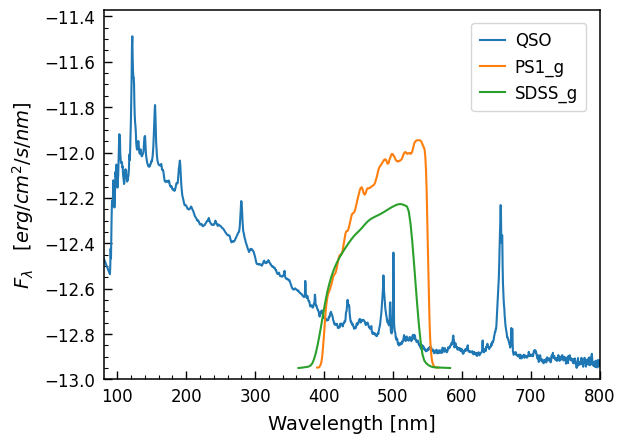

In [66]:
# plot spectrum
plt.plot(flambda_qso[:, 0], np.log10(flambda_qso[:, 1]), label='QSO')
plt.xlim(80, 800)
plt.ylim(-13)
plt.xlabel('Wavelength [nm]')
plt.ylabel('$F_{\lambda}$'+'   [$erg/cm^2/s/nm$]')

# add one filter on top
plt.plot(ps1_fc['g'][:, 0], ps1_fc['g'][:, 1]*2-12.95, label='PS1_g')
plt.plot(sdss_fc['g'][:, 0], sdss_fc['g'][:, 1]*2-12.95, label='SDSS_g')
plt.legend()

### 2. Compute AB Magnitude from spectrum
Need to use cds units

In [174]:
from scipy.interpolate import interp1d
import speclite
from speclite import filters
from astropy import constants

#### 2.1 Try with 'home-made' function

In [175]:
def get_AB(spec_wlen, flambda, fc_wlen, fc_tm):
    """
    Compute AB magnitude given a spectrum and a filter response, wlen must 
    be in nanometer.
    """
    # constants
    c = constants.c.to('nm/s')
    h = constants.h
    
    # interpolate curves
    spec_func = interp1d(spec_wlen, flambda, fill_value=(0, 0), bounds_error=False)
    fc_func = interp1d(fc_wlen, fc_tm, fill_value=(0, 0), bounds_error=False)
    
    # find the larger of the two wlen interval as the new sampling interval
    wlen_delta = np.max([np.median(spec_wlen[1:] - spec_wlen[:-1]), 
                         np.median(fc_wlen[1:] - fc_wlen[:-1])])
    
    # sample at uniform frequency and convert back to wlen
    wlen_range = fc_wlen.max() - fc_wlen.min()
    wlen = np.linspace(fc_wlen.min(), fc_wlen.max(), int(wlen_range/wlen_delta)+1) << u.nanometer
    freq = c/wlen
    flambda_new = spec_func(wlen.value) << u.erg/u.cm**2/u.s/u.nanometer
    fc_new = fc_func(wlen.value)
    
    # create center values
    wlen_cent = (wlen[:-1] + wlen[1:])/2
    freq_cent = ((freq[:-1] + freq[1:])/2).to(u.hertz)
    delta_freq = np.abs(freq[1:] - freq[:-1])    
    flambda_new_cent = (flambda_new[:-1] + flambda_new[1:])/2
    ffreq_new_cent = flambda_new_cent*wlen_cent/freq_cent
    fc_new_cent = (fc_new[:-1] + fc_new[1:])/2
    
    # integrate
    num = np.sum(ffreq_new_cent*fc_new_cent*delta_freq/(h*freq_cent))
    denom = np.sum(u.photometric.ABflux*fc_new_cent*delta_freq/(h*freq_cent))
    
    return np.log10((num/denom).decompose())*(-2.5)

In [180]:
get_AB(flambda_qso[:, 0], flambda_qso[:, 1], sdss_fc['g'][:, 0], sdss_fc['g'][:, 1])

<Quantity 13.625467>

#### 2.2 Try with $\texttt{speclite}$

In [177]:
# get wlen and flux (in approxiate units)
wlen = flambda_qso[:, 0]*u.nanometer
flux = flambda_qso[:, 1]*u.erg / (u.cm**2 * u.s * u.nanometer)

In [182]:
# make sdss filter response object
g0 = speclite.filters.FilterResponse(
    wavelength = sdss_fc['g'][:, 0]*u.nanometer, response = sdss_fc['g'][:, 1], 
    meta=dict(group_name='sdss_full', band_name='g'))

In [183]:
# compute g-band magnitude
g0.get_ab_magnitude(flux, wlen)

13.63092788834644

#### **Conclusion/Remark:**
'Home-made' function gives small offset relative to 'speclite', probably due to difference in implementation. 